Import des librairies et données nécessaires à l'étude:
===

In [1]:
# Librairies de calcul:
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Librairies de visualisation:
import matplotlib.pyplot as plt
import seaborn as sns

# Options globales pour l'output display:
pd.options.display.float_format = "{:.2f}".format
colors = ["#b2eca7","#ffcc97","#676283","#72bbff","#d2a0f2","#0abdc0"]

# Import des donnees:
Transactions_df = pd.read_csv("Transactions.csv", parse_dates = [1])
Customers_df = pd.read_csv("Customers.csv")
Products_df = pd.read_csv("Products.csv")

Observation et nettoyage des Dataframes:
===

Transactions_df:
---

In [2]:
Transactions_df.info()
Transactions_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [3]:
Transactions_df.loc[(Transactions_df["id_prod"]=="T_0"),("session_id","date","client_id")].describe()

,session_id,date,client_id
count,200,200,200
unique,1,39,2
top,s_0,test_2021-03-01 02:30:02.237413,ct_0
freq,200,13,106


In [4]:
Products_df.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

- Pas de valeurs nulles.
- On remarque des "test_2021*" qui ont tous le même id_prod et session_id (T_0 et s_0 respectivement), les client_id sont ct_0 (femme née en 2001) et ct_1 (homme née en 2001). Le produit T_0 à un prix négatif de -1€. 200 lignes sont concernées. On peut considérer qu'il s'agit de comptes de test faisant des transactions fictives dans le but de tester le site lors de son lancement. Les 200 lignes doivent être supprimées du dataframe. Il faudra aussi supprimer les deux faux clients et le produit fictif. Cependant il nous sera possible de revenir en arrière s'il s'avère qu'il ne s'agissait pas de tests.

In [5]:
Transactions_df.drop(Transactions_df[(Transactions_df["id_prod"] == "T_0")].index, inplace=True)
Transactions_df["date"] = pd.to_datetime(Transactions_df["date"], yearfirst= True)

In [6]:
Transactions_df.info()
Transactions_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 25.9+ MB


<ipython-input-6-d5b6b1656398>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  Transactions_df.describe()


,id_prod,date,session_id,client_id
count,679332,679332,679332,679332
unique,3266,679332,342315,8600
top,1_369,2021-09-23 22:15:02.832196,s_118668,c_1609
freq,2252,1,14,25488
first,NaN,2021-03-01 00:01:07.843138,NaN,NaN
last,NaN,2023-02-28 23:58:30.792755,NaN,NaN


- Les 200 lignes "test" ont bien été suprimées de notre dataframe.
- Les date sont bien lues en datetime.
- Dates du fuuutuuuure

Customers_df:
---

In [7]:
Customers_df.info()
Customers_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


,birth
count,8623.00
mean,1978.28
std,16.92
min,1929.00
25%,1966.00
50%,1979.00
75%,1992.00
max,2004.00


In [8]:
Customers_df.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

- Pas de valeurs manquantes
- Pas de valeurs aberrentes dans les années de naissance (min 2004 = 17 ans et max 1929 = 92 ans)
- On veut une colonne supplémentaire avec l'âge du client
- Nous avions décidé de supprimer les clients test (ct_1 et ct_0)

In [9]:
# Suppression des clients tests:
Customers_df.drop(Customers_df[(Customers_df["client_id"] == "ct_0")].index, inplace=True)
Customers_df.drop(Customers_df[(Customers_df["client_id"] == "ct_1")].index, inplace=True)

# Ajout d'une colonne "age" aux clients:
from datetime import datetime
current_year = datetime.now().strftime('%Y')

Customers_df["age"] = int(current_year) - Customers_df["birth"]

# Verifications:
Customers_df.info()
Customers_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8621 entries, 0 to 8622
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
 3   age        8621 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 336.8+ KB


,birth,age
count,8621.00,8621.00
mean,1978.28,42.72
std,16.92,16.92
min,1929.00,17.00
25%,1966.00,29.00
50%,1979.00,42.00
75%,1992.00,55.00
max,2004.00,92.00


Products_df:
---

In [10]:
Products_df.info()
Products_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


,price,categ
count,3287.00,3287.00
mean,21.86,0.37
std,29.85,0.62
min,-1.00,0.00
25%,6.99,0.00
50%,13.06,0.00
75%,22.99,1.00
max,300.00,2.00


In [11]:
Products_df.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

- Pas de valeurs manquantes, les types de données sont bons
- min = -1 correspond à un produit d'identifiant T_0, dans le df transaction nous avions pris la décision de supprimer les transactions en rapport avec ce que l'on suppose être un test.

In [12]:
# Suppression du produit test:
Products_df.drop(Products_df[(Products_df["id_prod"] == "T_0")].index, inplace=True)

# Verifications:
Products_df.info()
Products_df[["price"]].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3286 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB


,price
count,3286.00
mean,21.86
std,29.85
min,0.62
25%,6.99
50%,13.07
75%,22.99
max,300.00


Jointure des dataframes:
===

In [13]:
# Verifications d'unicite et recherche de duplicats:
print("Nombre de client_id:", Customers_df["client_id"].nunique())
print("Nombre de id_prod:", Products_df["id_prod"].nunique())

Duplicated_df = Transactions_df.loc[Transactions_df.duplicated()==True]
Duplicated_df.info()

Nombre de client_id: 8621
Nombre de id_prod: 3286
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_prod     0 non-null      object        
 1   date        0 non-null      datetime64[ns]
 2   session_id  0 non-null      object        
 3   client_id   0 non-null      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 0.0+ bytes


- client_id est une bonne clé pour Customers_df puisqu'il y a 8621 valeurs uniques sur 8621 valeurs au total (cf .describe() plus haut)
- id_prod est une bonne clé pour Products_df puisqu'il y a 3286 valeurs uniques sur 3286 valeurs au total (cf .describe() plus haut)
- La création d'un dataframe duplicate, afin de vérifier l'unicité des transacations, montre que les 679332 transactions répertoriées sont uniques

Ces vérifications faites on peut faire les jointures, on souhaite conserver toutes les informations présentes dans Transactions_df et les lier à celles présentes dans les deux autres dataframes. id_prod et client_id pourront être répétés plusieurs fois dans Transactions_df mais certains produits peuvent ne jamais avoir été vendus où certains clients peuvent ne jamais avoir effectué d'achats on souhaite pourtant conserver leurs informations. On fera une jointure "full outter". On s'attend donc à avoir *in fine* un dataframe avec 679332 lignes minimum (+ produits jamais vendus et clients non acheteurs). Il peut s'agir de clients n'achetant pas sur plusieurs sessions.

In [14]:
# Premiere jointure:
Interm_df = pd.merge(Transactions_df, Customers_df, on="client_id", how="outer")
Interm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679353 entries, 0 to 679352
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679353 non-null  object        
 4   sex         679353 non-null  object        
 5   birth       679353 non-null  int64         
 6   age         679353 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 41.5+ MB


In [15]:
# Seconde jointure:
Complet_df = pd.merge(Interm_df, Products_df, on="id_prod", how="outer")
Complet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679374 entries, 0 to 679373
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679353 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679353 non-null  object        
 4   sex         679353 non-null  object        
 5   birth       679353 non-null  float64       
 6   age         679353 non-null  float64       
 7   price       679132 non-null  float64       
 8   categ       679132 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 51.8+ MB


In [16]:
Complet_df.isna().sum()

id_prod        21
date           42
session_id     42
client_id      21
sex            21
birth          21
age            21
price         242
categ         242
dtype: int64

La première jointure, de Customers_df sur Transactions_df donne le dataframe Interm_df avec 679353 lignes.

La seconde jointure, de Products_df sur Interm_df donne le dataframe Comlpet_df avec 679374 lignes.

Le nombre de NaN est plus important qu'attendu:
- On retrouve 21 clients qui n'ont pas fait d'achats mais qui ont un compte sur notre site.
- On a également 21 produits qui ne se sont jamais vendus mais qui sont présents dans notre référencement.
- Les 242 NaN dans price et categ ne sont pas normaux même en prennant en compte les 21 NaN "corresspondants" aux clients non achateurs. Ils correspondent tous à différentes sessions de différents clients concernant le produit 0_2245 qui ne se retrouve pas dans le Products_df. Il s'agit probablement d'une suppression par inadvertance mais il faudrait ajouter les informations concernant le prix de ce produit, la catégorie étant donnée par la structure de l'identifiant. Pour que nos calculs soient plus proches de la réalité nous choisissons de le remplacer temporairement par la médiane des prix des livres de catégorie 0 (9,99€) moins sensible aux outliers que la moyenne.

In [17]:
# Remplacement des donnees manquantes de 0_2245:
Complet_df["categ"] = np.where(Complet_df["id_prod"] == "0_2245",
                               0,
                               Complet_df["categ"])

Complet_df["price"] = np.where(Complet_df["id_prod"] == "0_2245",
                               Complet_df.loc[(Complet_df["categ"]==0),"price"].median(),
                               Complet_df["price"])

Complet_df.isna().sum()

id_prod       21
date          42
session_id    42
client_id     21
sex           21
birth         21
age           21
price         21
categ         21
dtype: int64

In [18]:
# Creation de Ventes_df:
Ventes_df = Complet_df.dropna()
Ventes_df.info()

# Facilite la manipulation des dates:
Ventes_df["year"] = Ventes_df["date"].dt.year
Ventes_df["month"] = Ventes_df["date"].dt.month
Ventes_df["day"] = Ventes_df["date"].dt.day

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   sex         679332 non-null  object        
 5   birth       679332 non-null  float64       
 6   age         679332 non-null  float64       
 7   price       679332 non-null  float64       
 8   categ       679332 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 51.8+ MB


<ipython-input-18-28a03963a8d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ventes_df["year"] = Ventes_df["date"].dt.year
<ipython-input-18-28a03963a8d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ventes_df["month"] = Ventes_df["date"].dt.month
<ipython-input-18-28a03963a8d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Pour faciliter les calculs par la suite on créer un dataframe ne contenant que les ventes (donc pas les clients non acheteurs ou les produits non vendus qui seront analysés à part).

Analyse des différents indicateurs de vente:
===

Différents indicateurs et graphiques autour du CA dont évolution dans le temps:
---

In [19]:
# CA total:
ca_tot = Complet_df.loc[(Complet_df["client_id"] != "NaN"),"price"].sum()
ventes_tot = Ventes_df["session_id"].count()

print("Le chiffre d'affaires total est de", ca_tot, "€")
print("pour un total de", ventes_tot, "ventes.")

Le chiffre d'affaires total est de 11856731.75 €
pour un total de 679332 ventes.


In [20]:
# CA annuel:
ca_annuel = Ventes_df.groupby(["year"])["price"].sum()
print("Chiffres d'affaires annuels:\n", ca_annuel)

# Nombre de ventes annuel:
ventes_annuelles = Ventes_df.groupby(["year"])["session_id"].count()
print("Nombre de ventes annuelles:\n", ventes_annuelles)

Chiffres d'affaires annuels:
 year
2021   4771695.69
2022   6109880.61
2023    974360.17
Name: price, dtype: float64
Nombre de ventes annuelles:
 year
2021    278335
2022    346500
2023     54497
Name: session_id, dtype: int64


In [21]:
print(Complet_df["date"].nlargest(1))

356690   2023-02-28 23:58:30.792755
Name: date, dtype: datetime64[ns]


2022 est donc notre meilleure année en matière de chiffre d'affaires et de nombre de ventes jusqu'à maintenant, cependant les données de 2023 ne sont pas complètes, la dernière session datant du 28 février à 23h58. Il faudrait donc comparer mensuellement plutôt pour voir si la situation en février 2023 est meilleure que les années précédentes pour la même période. La représentation graphique n'est pas nécessaire ici.

Text(0.5, 1.0, "Evolution mensuelle du chiffre d'affaires")

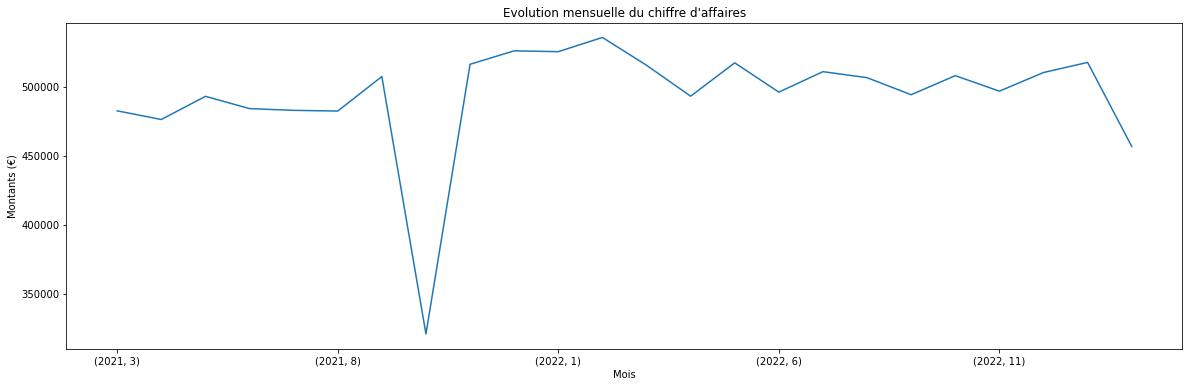

In [22]:
# CA mensuel:
Ventes_df = Ventes_df.sort_values(["date"],ascending=True)
ca_mensu = Ventes_df.groupby(["year","month"])["price"].sum()

# Nombre de ventes mensuelles:
ventes_mensu = Ventes_df.groupby(["year", "month"])["session_id"].count()

# Graphique:
plt.figure(figsize = (20,6))
ca_mensu.plot()
plt.xlabel("Mois")
plt.ylabel("Montants (€)")
plt.title("Evolution mensuelle du chiffre d'affaires")

Baisse du chiffre d'affaires inattendue en octobre.

In [23]:
# Creation d'un dataframe specifique par categories avec fonction d'agregation:
MensAg_df = Ventes_df[["categ", "price", "year", "month"]]
MensAg_df = pd.pivot_table(MensAg_df, index=["year","month"], columns=["categ"], aggfunc=["sum", "count"]).reset_index()
MensAg_df.columns = ["year", "month", "categ_0", "categ_1", "categ_2", "vol_categ_0", "vol_categ_1", "vol_categ_2"]

Text(0.5, 1.0, 'évolution mensuelle du volume de vente par catégorie')

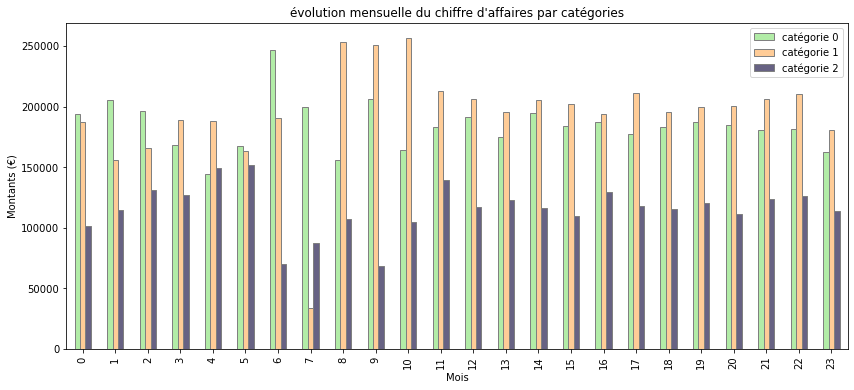

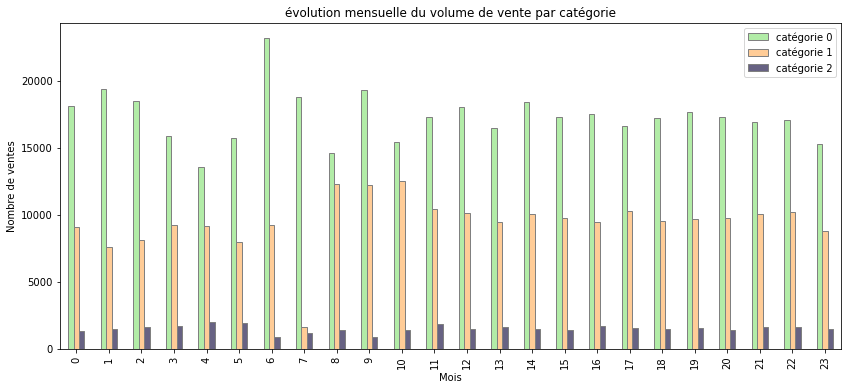

In [24]:
# Graphique CA par mois:
MensAg_df[["categ_0", "categ_1", "categ_2"]].plot.bar(figsize=(14,6),color=colors,edgecolor = "grey", linewidth = 1)
plt.legend(["catégorie 0", "catégorie 1", "catégorie 2"])
plt.xlabel("Mois")
plt.ylabel("Montants (€)")
plt.title("évolution mensuelle du chiffre d'affaires par catégories")

# Graphique volume des ventes:
MensAg_df[["vol_categ_0", "vol_categ_1", "vol_categ_2"]].plot.bar(figsize=(14,6),color=colors,edgecolor = "grey", linewidth = 1)
plt.legend(["catégorie 0", "catégorie 1", "catégorie 2"])
plt.xlabel("Mois")
plt.ylabel("Nombre de ventes")
plt.title("évolution mensuelle du volume de vente par catégorie")

In [25]:
# Modification du dataframe specifique par categories avec fonction d'agregation:
MensAg_df = Ventes_df[["categ", "price", "year", "month","day"]]
MensAg_df = pd.pivot_table(MensAg_df, index=["year","month","day"], columns=["categ"], aggfunc=["sum", "count"]).reset_index()
MensAg_df.columns = ["year", "month","day", "categ_0", "categ_1", "categ_2", "vol_categ_0", "vol_categ_1", "vol_categ_2"]

# Nombre de ventes journalieres moyennes par mois:
ventes_jour = MensAg_df.groupby(["day","month","year"])["vol_categ_0", "vol_categ_1", "vol_categ_2"].sum().mean()
print(ventes_jour)

vol_categ_0   569.42
vol_categ_1   311.19
vol_categ_2    49.98
dtype: float64


<ipython-input-25-b1a4dc4bc9cd>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ventes_jour = MensAg_df.groupby(["day","month","year"])["vol_categ_0", "vol_categ_1", "vol_categ_2"].sum().mean()


On remarque que les ventes de livres de catégorie 1 on subit une forte baisse au mois d'octobre 2021, cette baisse ne se retrouve pas plus tard, il semble qu'il y ait eu un problème.

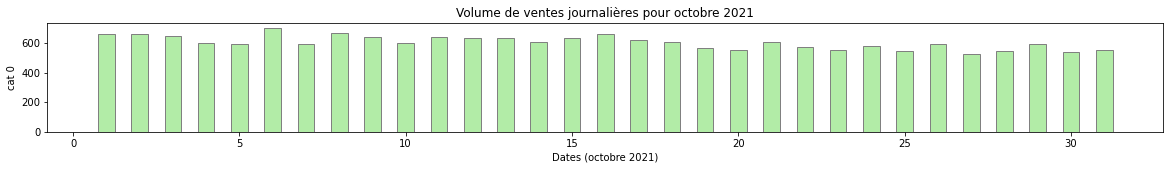

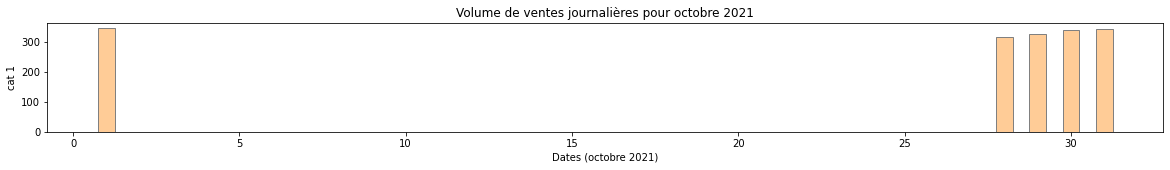

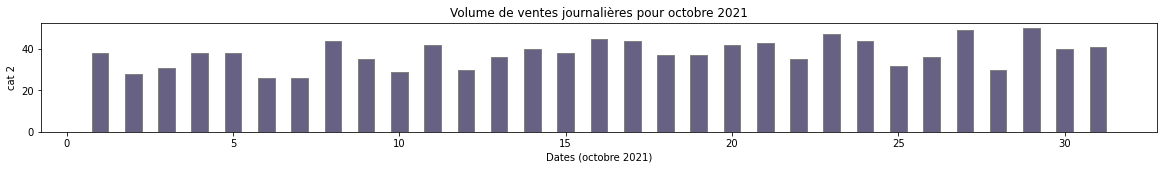

In [26]:
# On se penche en detail sur le mois d'octobre 2021:
Octobre_df = Ventes_df.loc[(Ventes_df["year"] == 2021) & (Ventes_df["month"] == 10), ["day", "price","categ"]]
Octobre_df = Octobre_df.groupby(["day","categ"]).agg({"price":["sum","count"]}).reset_index()
Octobre_df.columns = ["day", "categ", "ca", "volume"]
Octobre_df = pd.pivot_table(Octobre_df, columns=["categ"], index=["day"]).reset_index()
Octobre_df.columns = ["day", 'ca_0', 'ca_1', 'ca_2', 'vol_0', 'vol_1', 'vol_2']

color=colors
for i, cat in enumerate([0,1,2]):
    plt.figure(figsize=(44,2))
    plt.subplot(1,2,2)
    plt.bar(Octobre_df["day"], Octobre_df[f'vol_{cat}'], width=0.5, color=color[i],edgecolor = "grey", linewidth = 1)
    plt.xlabel("Dates (octobre 2021)")
    plt.ylabel(f'cat {cat}')
    plt.title("Volume de ventes journalières pour octobre 2021")
    plt.show()


Il n'y a pas eu de ventes de livres de catégorie 1 entre le 1er et le 28 octobre 2021, ce qui est probablement dû à un problème d'acquisition des données dans notre pipeline.

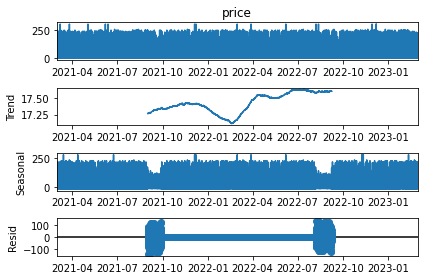

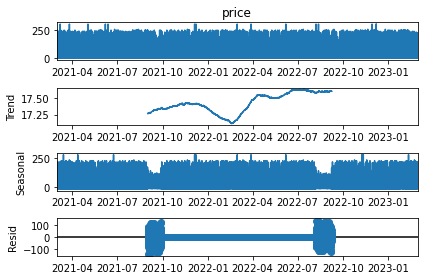

In [27]:
# Saisonnalite et tendance:
Ventes_df.reset_index(inplace=True)
Ventes_df["date"] = pd.to_datetime(Ventes_df["date"])
Ventes_df = Ventes_df.set_index("date")

sm.tsa.seasonal_decompose(Ventes_df["price"],period=325000).plot()

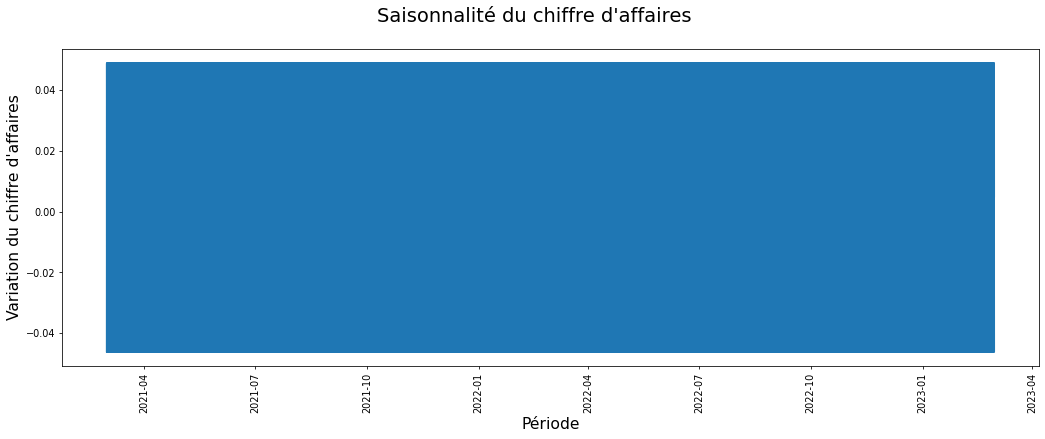

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
s=sm.tsa.seasonal_decompose(Ventes_df.price, period=6, extrapolate_trend=1)
#s.resid
s.seasonal
s.trend

# Graphique:
plt.figure(figsize = (18,6), dpi=70).suptitle("Saisonnalité du chiffre d'affaires", fontsize=20)
plt.plot(s.seasonal)
plt.xticks(rotation=90)
plt.xlabel("Période", fontsize=16)
plt.ylabel("Variation du chiffre d'affaires", fontsize=16)
plt.show()

In [29]:
# Autocorrelation
autocor = np.corrcoef(np.array([Ventes_df["price"][:-1], Ventes_df["price"][1:]]))
print(autocor)

[[ 1.         -0.00227463]
 [-0.00227463  1.        ]]


year  month
2021  3             NaN
      4             NaN
      5       483934.36
      6       484477.01
      7       486685.75
      8       483136.18
      9       490870.21
      10      436867.98
      11      448165.62
      12      454374.50
2022  1       522547.93
      2       529019.18
      3       525545.58
      4       514795.54
      5       508665.89
      6       502172.43
      7       508093.83
      8       504512.08
      9       503884.88
      10      502923.10
      11      499665.65
      12      505023.98
2023  1       508221.58
      2       494879.87
Name: price, dtype: float64


Text(0.5, 1.0, "Moyenne mobile du chiffre d'affaire")

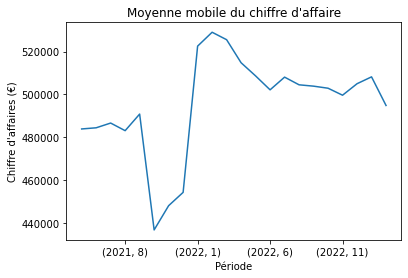

In [30]:
# Decomposition en moyenne mobile:
MovingAverage = ca_mensu.rolling(3).mean()
print(MovingAverage)

# Graphique:
MovingAverage.plot()
plt.xlabel("Période")
plt.ylabel("Chiffre d'affaires (€)")
plt.title("Moyenne mobile du chiffre d'affaire")

Zoom sur les références:
---

In [31]:
# Meilleures et pires ventes:
nbr_ventes_ref = Ventes_df.groupby(["id_prod"])["session_id"].count()

print("Références les plus vendues")
print(nbr_ventes_ref.nlargest(10))
print("Références les moins vendues")
print(nbr_ventes_ref.nsmallest(10))

Références les plus vendues
id_prod
1_369    2252
1_417    2189
1_414    2180
1_498    2128
1_425    2096
1_403    1960
1_412    1951
1_413    1945
1_406    1939
1_407    1935
Name: session_id, dtype: int64
Références les moins vendues
id_prod
0_1151    1
0_1284    1
0_1379    1
0_1498    1
0_1539    1
0_1601    1
0_1633    1
0_1683    1
0_1728    1
0_2201    1
Name: session_id, dtype: int64


Nos 10 best sellers appartiennent tous à la catégorie 1 tandis que les dix pires ventes hors des 21 produits non vendus appartiennent à la catégorie 0.

indice de Gini: 0.694


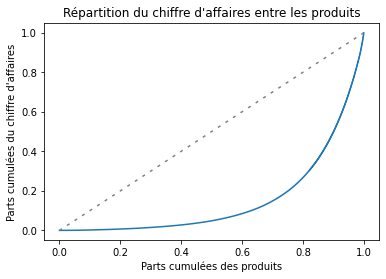

In [32]:
# Courbe de Lorentz: (Repartition du CA par produits)
lorenz_CA_prod = np.cumsum(np.sort(nbr_ventes_ref)) / nbr_ventes_ref.sum()
lorenz_CA_prod = np.append([0], lorenz_CA_prod)
plt.plot(np.linspace(0,1,len(lorenz_CA_prod)), lorenz_CA_prod, drawstyle='steps-post'),
plt.plot(np.linspace(0,1,len(lorenz_CA_prod)), np.linspace(0,1,len(lorenz_CA_prod)),color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des produits")
plt.title("Répartition du chiffre d'affaires entre les produits")
aire_ss_courbe_CA_prod = lorenz_CA_prod[:-1].sum() / len(lorenz_CA_prod)
S_ca_prod = 0.5 - aire_ss_courbe_CA_prod
gini_CA_prod = 2* S_ca_prod
print("indice de Gini:",round(gini_CA_prod,3))

L'indice de Gini s'éloigne fortement de 0, le poids des produits dans le chiffre d'affaires global est donc très inégal.

Répartitions des références par catégories:
 categ
0    2308
1     739
2     239
Name: id_prod, dtype: int64
Nombre de ventes par catégories:
 categ
0.00    415680
1.00    227169
2.00     36483
Name: index, dtype: int64
Prix moyen d'un livre selon sa catégorie:
 categ
0    11.73
1    25.53
2   108.35
Name: price, dtype: float64
Chiffre d'affaires par catégorie
 categ
0.00   4421938.76
1.00   4653722.69
2.00   2780275.02
Name: price, dtype: float64


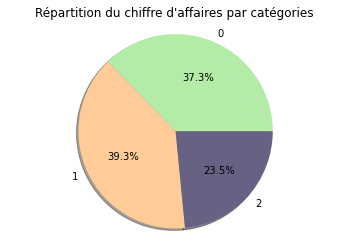

In [33]:
# Repartition des references parmis les categories:
repartition_categ = Products_df.groupby(["categ"])["id_prod"].count()
print("Répartitions des références par catégories:\n",repartition_categ)

# Volume de ventes par categories:
vol_categ = Ventes_df.groupby(["categ"])["index"].count()

print("Nombre de ventes par catégories:\n", vol_categ)

# Prix moyen par categories:
prix_categ = Products_df.groupby(["categ"])["price"].mean()
print("Prix moyen d'un livre selon sa catégorie:\n",prix_categ)

# CA par categories:
ca_categ = Ventes_df.groupby(Ventes_df["categ"])["price"].sum()
print("Chiffre d'affaires par catégorie\n",ca_categ)

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(ca_categ,
        labels=["0","1","2"],
        autopct="%1.1f%%",
        colors=colors,
        shadow=True)
ax1.axis("equal")
plt.title("Répartition du chiffre d'affaires par catégories")
plt.show()

Différences de prix marquées, en particulier pour les livres de la catégorie 2. On note également que nos meilleures ventes se font sur la catégorie 1 qui est la catégorie intermédiaire en prix moyen.

Profils clients
---

In [34]:
# Meilleurs clients:
best_client = Ventes_df.groupby(["client_id"])["price"].sum()

print("Clients ayant le plus dépensé")
print(best_client.nlargest(10))

Clients ayant le plus dépensé
client_id
c_1609   324033.35
c_4958   289760.34
c_6714   153658.86
c_3454   113667.90
c_3263     5276.87
c_1570     5271.62
c_2899     5214.05
c_2140     5208.82
c_7319     5155.77
c_8026     5092.57
Name: price, dtype: float64


c_1609, (homme 41ans) achète plusieurs fois les mêmes livres, il peut s'agir d'un revendeur (libraires, bibliothécaires), les trois autres aussi d'ailleurs.
Il est possible de proposer un accompagnement presonnalisé à ces clients puisqu'ils n'auront pas les mêmes besoins que des particuliers.

In [35]:
# Nombre d'achats et montant moyen par client:
nbr_achats_moy = Complet_df.groupby(["client_id"])["session_id"].count().mean()
montant_achats_moy = Ventes_df.groupby(["client_id"])["price"].sum().mean()

print("Le nombre moyen d'achat par client depuis l'ouverture de notre site est", round(nbr_achats_moy,2))
print("Le montant moyen d'achat par client depuis l'ouverture de notre site est", round(montant_achats_moy,2))

Le nombre moyen d'achat par client depuis l'ouverture de notre site est 78.8
Le montant moyen d'achat par client depuis l'ouverture de notre site est 1378.6


indice de Gini: 0.447


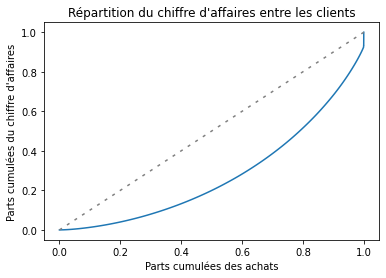

In [36]:
# Courbe de Lorentz: (repartition du CA par clients)
lorenz_CA_client = np.cumsum(np.sort(best_client)) / best_client.sum()
lorenz_CA_client = np.append([0], lorenz_CA_client)
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), lorenz_CA_client, drawstyle="steps-post")
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), np.linspace(0,1,len(lorenz_CA_client)), color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des achats")
plt.title("Répartition du chiffre d'affaires entre les clients")
aire_ss_courbe_CA_client = lorenz_CA_client[:-1].sum() / len(lorenz_CA_client)
S_ca_client = 0.5 - aire_ss_courbe_CA_client
gini_CA_client = 2*S_ca_client
print("indice de Gini:",round(gini_CA_client,3))

In [37]:
# Nombre moyen d'achats par sessions:
print("Il y a eu",
      Complet_df["session_id"].nunique(),
      "sessions")

print("Une session aboutie en moyenne à",
      round(Complet_df.groupby(["session_id","client_id"])["id_prod"].count().mean(),2),
      "achats")

Il y a eu 342315 sessions
Une session aboutie en moyenne à 1.98 achats


Il y a 342 315 sessions pour un total de 679 332 transactions, il est donc courant d'avoir plusieurs transactions par sessions.
En moyenne une session aboutie sur 1,98 achats.

Analyse ciblée clients:
===

sex
f    4490
m    4131
Name: client_id, dtype: int64


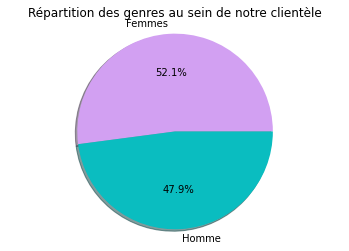

In [38]:
# Repartition des genres parmis nos clients:
repartition_genre = Customers_df.groupby(["sex"])["client_id"].count()
print(repartition_genre)

# Graphique:
fig2, ax2 = plt.subplots()
ax2.pie(repartition_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["#d2a0f2","#0abdc0"],
        shadow=True)
ax2.axis("equal")
plt.title("Répartition des genres au sein de notre clientèle")
plt.show()

montant total des achats par genre:
 sex
f   5860851.96
m   5995084.51
Name: price, dtype: float64
nombre total d'achats par genre:
 sex
f    338402
m    340930
Name: price, dtype: int64
montant moyen des achats par genre:
 sex
f   17.32
m   17.58
Name: price, dtype: float64


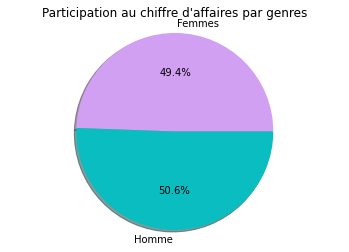

In [39]:
# Depenses par genres:
repartition_achats_genre = Ventes_df.groupby(["sex"])["price"].sum()
print("montant total des achats par genre:\n", repartition_achats_genre)

nbr_achats_genre = Ventes_df.groupby(["sex"])["price"].count()
print("nombre total d'achats par genre:\n", nbr_achats_genre)

moy_achats_genre = Ventes_df.groupby(["sex"])["price"].mean()
print("montant moyen des achats par genre:\n", moy_achats_genre)


# Graphique:
fig3, ax3 = plt.subplots()
ax3.pie(repartition_achats_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["#d2a0f2","#0abdc0"],
        shadow=True)
ax3.axis("equal")
plt.title("Participation au chiffre d'affaires par genres")
plt.show()

In [40]:
# Table de contingence pour Chi²:
categ_sex = pd.crosstab(Ventes_df["sex"],Ventes_df["categ"])
print(categ_sex)

# Chi²:
cs_chi2, cs_p, cs_dof, cs_exp = st.chi2_contingency(categ_sex)

print("Les fréquences théoriques sont:\n", cs_exp,3)
print(f"Ce qui donne un X² de {cs_chi2:.3f} à", cs_dof, "ddl")
print(f"soit une p-value de", cs_p)

# Calcul V de Cramer:
n_cs = len(Ventes_df)
minDim_cs = min(categ_sex.shape)-1

V_cs = np.sqrt((cs_chi2/n_cs) / minDim_cs)

print("Le V de Cramer vaux:", V_cs)

categ    0.00    1.00   2.00
sex                         
f      206220  114899  17283
m      209460  112270  19200
Les fréquences théoriques sont:
 [[207066.56444861 113161.81769444  18173.61785695]
 [208613.43555139 114007.18230556  18309.38214305]] 3
Ce qui donne un X² de 147.003 à 2 ddl
soit une p-value de 1.1989607410166063e-32
Le V de Cramer vaux: 0.014710294817475282


L'hypothèse nulle est ici l'indépendance des variables catégories achetées et genre.
Dans tous les cas que l'on prenne un seuil à 5% (0,05) ou 1% (0,01), la p-value sera ici toujours très inférieure au seuil de significativité, l'hypothèse nulle est rejetée, les catégories des livres achetées ne dépendent donc pas du genre de l'acheteur.

[]

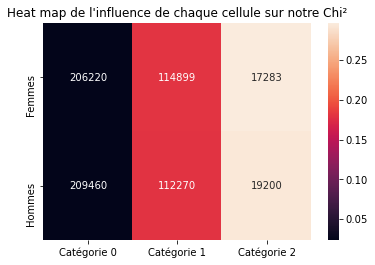

In [41]:
# Heat map pour identifier les cellules les plus influantes sur le Chi²:
len_i = categ_sex.shape[0]
len_j = categ_sex.shape[1]
xij = np.zeros((len_i, len_j))
for i in range(len_i):
    for j in range(len_j):
        xij[i,j] = (categ_sex.values[i,j]-cs_exp[i,j])**2 / cs_exp[i,j]

sns.heatmap(xij/cs_chi2,
            annot=categ_sex,
            fmt='d',
            yticklabels=["Femmes","Hommes"],
            xticklabels=["Catégorie 0", "Catégorie 1", "Catégorie 2"])
plt.title("Heat map de l'influence de chaque cellule sur notre Chi²")
plt.plot()

La map nous confirme qu'il n'y a que peu de variations entre genres au sein des catégories, l'achat d'une catégorie en particulier ne dépenderait donc pas du genre de l'acheteur.

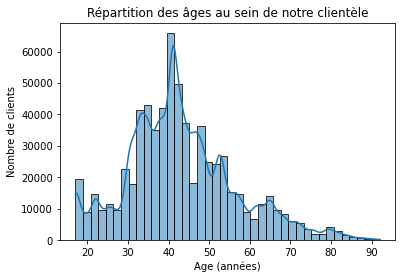

In [42]:
# Repartition des ages parmis nos clients:
sns.histplot(data=Complet_df["age"],
             bins=40,
             kde=True)
plt.title("Répartition des âges au sein de notre clientèle")
plt.ylabel("Nombre de clients")
plt.xlabel("Age (années)")
plt.show()

In [43]:
# Test de Normalite de la repartition des ages:
print(st.anderson(Customers_df["age"], dist="norm"))

AndersonResult(statistic=54.304839298933075, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


On utilise le test d'Anderson Darling car il est non paramétrique et utilisé pour les grands échantillons.
H0 = les données suivent une distribution normale
alpha 1%
statistique du test d'Anderson (54) > valeure critique (1)
On rejette H0.
On considère que l'âge ne suit pas une distribution normale avec un risque d'erreure 1%

Autres tests possibles mais moins puissants/appropriés:
- print(st.shapiro(Customers_df["age"]))
- print(st.jarque_bera(Customers_df["age"]))
- print(st.kstest(Customers_df["age"], cdf="norm"))

In [44]:
# Ajout des tranches d'ages:
Ventes_df["age_range"] = pd.cut(x= Ventes_df["age"], bins=[0,30,60,110], include_lowest=False, ordered=True)

# Repartition des achats par tranches d'ages:
repartition_achats_age_range = Ventes_df.groupby(["age_range"])["price"].sum()
print("montant total des achats par tranches d'age:\n", repartition_achats_age_range)

# Nombre d'achats par tranches d'ages:
nbr_achats_age_range = Ventes_df.groupby(["age_range"])["price"].count()
print("nombre total d'achats par tranches d'age:\n",nbr_achats_age_range)

# Motant moyen des achats par tranches d'ages:
moy_achats_age_range = Ventes_df.groupby(["age_range"])["price"].mean()
print("montant moyen des achats par tranches d'age:\n", moy_achats_age_range)

montant total des achats par tranches d'age:
 age_range
(0, 30]     3519169.68
(30, 60]    6978995.72
(60, 110]   1357771.07
Name: price, dtype: float64
nombre total d'achats par tranches d'age:
 age_range
(0, 30]       96642
(30, 60]     501634
(60, 110]     81056
Name: price, dtype: int64
montant moyen des achats par tranches d'age:
 age_range
(0, 30]     36.41
(30, 60]    13.91
(60, 110]   16.75
Name: price, dtype: float64


Bien que les moins de 30 ans dépensent plus en moyenne par achats ils nous rapportent moins que les 30- 60 ans qui font beaucoup plus d'achats sur notre site et donc nous rapportent plus en terme de chiffre brut. Cela est très probablement dû à leur sur représentation au sein de nontre base de clientèle. Il serait intéressant de cibler pour les prochaines campagnes marketing les moins de 30 ans afin d'en augmenter le nombre parmi notre clientèle.

Corrélation de Speraman: SpearmanrResult(correlation=-0.8576076555023923, pvalue=4.57972879340901e-23)


Text(0.5, 1.0, 'Motant des achats par âges')

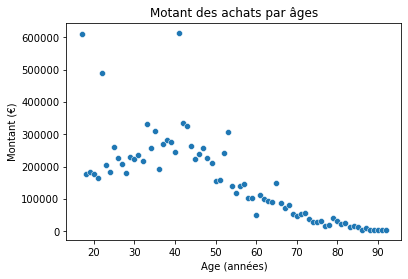

In [45]:
# Lien entre l'age et le montant des achats:
age = Ventes_df.groupby(["age"])["client_id"].count()
tot_achats_age = Ventes_df.groupby(["age"])["price"].sum()

# Correlation entre l'age et le montant total des achats:
print("Corrélation de Speraman:", st.spearmanr(tot_achats_age.index, tot_achats_age.values))

# Graphique:
sns.scatterplot(data= tot_achats_age)
plt.ylabel("Montant (€)")
plt.xlabel("Age (années)")
plt.title("Motant des achats par âges")

Les ages ne suivent pas une distribution Normale, le test est forcément non pramétrique, on utilise donc un test de corrélation de Spearman.

Corrélation de Speraman: SpearmanrResult(correlation=-0.6846206425153794, pvalue=9.152883867240306e-12)


Text(0.5, 1.0, "Nombre d'achats selon l'âge")

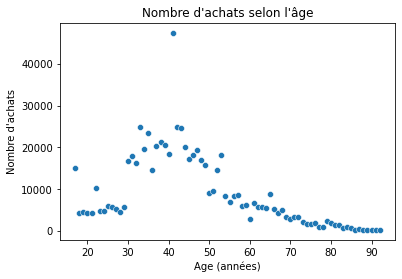

In [46]:
# Lien entre l'age et la taille du panier:
nbr_achats_age = Ventes_df.groupby(["age"])["session_id"].count()

# Correlation entre l'age et le montant total des achats:
print("Corrélation de Speraman:", st.spearmanr(nbr_achats_age.index,nbr_achats_age.values))

# Graphique:
sns.scatterplot(data= nbr_achats_age)
plt.ylabel("Nombre d'achats")
plt.xlabel("Age (années)")
plt.title("Nombre d'achats selon l'âge")

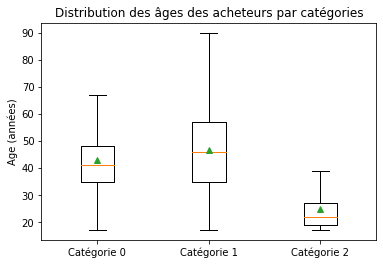

In [47]:
# Categories les plus achetees par age:
categ = Ventes_df["categ"].unique()
categ_age = {categ: Ventes_df.loc[Ventes_df["categ"]==categ, "age"] for categ in categ}

# Graphique:
plt.boxplot([
    categ_age[0],
    categ_age[1],
    categ_age[2]]
    ,labels=["Catégorie 0", "Catégorie 1", "Catégorie 2"],showmeans=True, showfliers=False)
plt.ylabel("Age (années)")
plt.title("Distribution des âges des acheteurs par catégories")
plt.show()

In [48]:
# Lien entre age et categorie achetees:
print(type(categ_age[0].values))
print(st.kruskal(categ_age[0], categ_age[1], categ_age[2]))

<class 'numpy.ndarray'>
KruskalResult(statistic=79350.86927924873, pvalue=0.0)


Le test de Kruskal Wallis, est non paramétrique, les groupes doivent contenir plus de cinq individus. p-val < 0,01 on rejette l'hypothèse nulle selon laquelle il n'y aurait pas de différence entre l'âge median d'achat par catégorie.
Kruskal est un test de rang.

age
17   629.96
18   204.12
19   202.09
20   181.12
21   192.34
      ...  
88    14.95
89    11.42
90     6.61
91     8.07
92     6.51
Name: session_id, Length: 76, dtype: float64
Corrélation de Speraman: SpearmanrResult(correlation=0.20608355165108688, pvalue=4.272028369734415e-83)


Text(0.5, 1.0, "Fréquence mensuelle d'achat par âge")

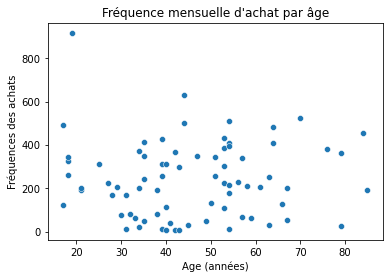

In [49]:
# Frequence d'achat mensuelle:
freq_mensu= Ventes_df.groupby(["client_id", "year", "month"])["session_id"].nunique().groupby(["client_id"]).mean().reset_index()

# Ajout des ages au df frequence mensuelle:
freq_mensu = pd.merge(Customers_df, freq_mensu, on="client_id",how="outer")
freq_mensu = freq_mensu.dropna()                                                #On enleve les clients non acheteurs

# Lien entre l'age et la frequence d'achat mensuelle:
freq_age = freq_mensu.groupby(["age"])["session_id"].sum()

print(freq_age)

# Ces lignes peuvent être ajoutees ou retirees pour avoir la correlation et le scatterplot en prennant en compte les libraires:
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_1609")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_3454")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_4958")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_6714")].index, inplace=True)

# Correlation entre l'age et le montant total des achats
print("Corrélation de Speraman:", st.spearmanr(freq_mensu["age"], freq_mensu["session_id"]))

# Graphique
sns.scatterplot(x=freq_mensu["age"], y=freq_age)
plt.ylabel("Fréquences des achats")
plt.xlabel("Age (années)")
plt.title("Fréquence mensuelle d'achat par âge")

#Rq: changer nom session_id par freq_m dans df freq_mensu

L'échelle ne va que jusqu'à 80 contrairement aux autres scatterplot mais les 90 et plus sont bien présents dans le dataframe.

Probabilité conditionnelle
---

Probabilité pour un client d’acheter la référence 0_525 sachant qu’il a acheté la référence 2_159 (*une probabilité conditionnelle est la probabilité de B sachant A. P(B|A) =P(A∩B) /P(A)*)
Notant :
A = le client à acheté la référence 2_159
B = le client à acheté la référence 0_525

P(A)= nombre d'achats de 2_159 / nombre d'achats totaux = 650/679332
P(B)= nombre d'achats de 0_525 / nombre d'achats totaux = 500/679332
P(A∩B)= nombre d'achats de 2_159 & 0_525 / nombre d'achats totaux = 499 / 679332

Les évènements sont indépendants ssi p(A∩B) = P(A) * P(B)

In [50]:
# Calcul des probabilites de base:
achat_2_159 = Ventes_df.loc[(Ventes_df["id_prod"] == "2_159"),"session_id"]
achat_0_525 = Ventes_df.loc[(Ventes_df["id_prod"] == "0_525"),"session_id"]

p_achat_2_159 = achat_2_159.count()/ventes_tot
p_achat_0_525 = achat_0_525.count()/ventes_tot
p_achat_2_159n_achat_0_525 = len(set(achat_2_159).intersection(set(achat_0_525)))/ventes_tot

print("P(A)=",p_achat_2_159)
print("P(B)=",p_achat_0_525)
print("P(A∩B)=",p_achat_2_159n_achat_0_525)

# L'achat des deux references est-il independant?
if p_achat_2_159n_achat_0_525==p_achat_2_159*p_achat_0_525:
    print("Les évenements sont indépendants")
else:
    print("Les évenements ne sont pas indépendants")

# Probabilite pour un client d’acheter la reference 0_525 sachants qu’il a achete la reference 2_159:
print("P(B|A)=", p_achat_2_159n_achat_0_525/p_achat_2_159)

P(A)= 0.0009568222901320709
P(B)= 0.0007360171462554391
P(A∩B)= 0.0007345451119629283
Les évenements ne sont pas indépendants
P(B|A)= 0.7676923076923077


P(A∩B) =/= P(A) x P(B), les deux achats ne sont donc pas indépendants (on le remarque facilement en comparant le nombre d'achats de 0_525 seul vs le nombre d'achats de 0_525 avec 2_159). La probabilité pour un client d'acheter 0_525 sachant qu'il a acheté 2_519 est forte (supérieure à 0,76).

On pourrait collecter dans notre pipeline la durée des sessions, plus d'informations sur les clients (catégorie socio-professionnelle, zone géographique, date de création de compte), sur les produits (catégories plus détaillées, date de sortie de l'ouvrage). Il faudrait également comparer le comportement en ligne et hors ligne, en particulier pour les clients utilisant les deux modes d'achats.